# **The Dapper Squirrels**
**Using Spark GraphX**



---


# **Spark and GraphFrames Set Up**


In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

     |████████████████████████████████| 281.3 MB 30 kB/s 
     |████████████████████████████████| 198 kB 41.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=1b1e67f13a439cc39bebcd351faafed54d651f6e85375c8bdcc4cbdcac28b901
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
     |████████████████████████████████| 154 kB 5.4 MB/s 


**Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)**

**Upload it in the Google Colab Files folder. Can be found in the left pane of this window.**

In [ ]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [ ]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd
import psycopg2
import networkx as nx
import matplotlib.pyplot as plt

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [ ]:
cursor = conn.cursor()

# **Question 1**
Making nodes of officers and victims by their income, race, locations, and even unsupervised machine learning models to learn the cluster and see if there is a potential connection between officers and victims.



## 1.1 Learn the Connection from Race


**Following query creates nodes and edges to answer the questions.**



*   **nodes**: race
*   **edges**: src(officer id), dist(race) and relationship(complainat)

### 1.1.1 Graph Visualization Sample
In this section, we plot the visualized graph of the connection of the officer and the victim by race with part of the data.

#### Build GraphFrame

In [ ]:
edges_query = "SELECT officer_id src, race dst,  count(data_complainant.allegation_id) relationship FROM data_complainant LEFT JOIN data_officerallegation d on data_complainant.allegation_id = d.allegation_id WHERE officer_id IS NOT NULL and race IS NOT NULL and not race = '' group by 1,2 ORDER BY officer_id asc limit 100;"

In [ ]:
nodes_query = "SELECT DISTINCT race id from data_complainant where not race ='';"

In [ ]:
# query edges
cursor.execute(edges_query)
edges = cursor.fetchall()
df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

In [ ]:
# quert nodes
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465
df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

shape is: 5


In [ ]:
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)
cpdb = GraphFrame(nodes, edges_)

In [ ]:
edge_labels = []
edge_labels=dict([((row[0],row[1]),row[2])for i,row in df_edges.iterrows()])
gx = cpdb   
g = nx.from_pandas_edgelist(df_edges, source='src', target='dst',edge_attr='relationship', create_using=nx.DiGraph())
g.add_nodes_from(gx.vertices.toPandas()['id'])
color_map = ['red' if node in gx.vertices.toPandas()['id'].values else 'green' for node in g] 
pos = nx.shell_layout(g)

#### Plot

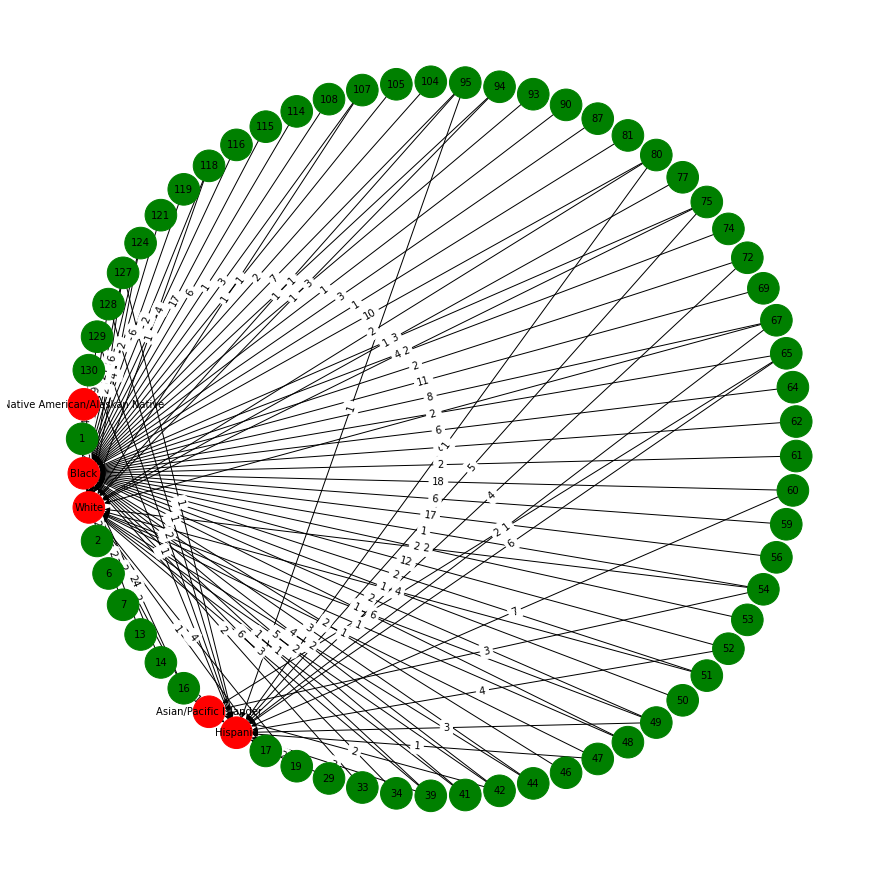

In [ ]:
plt.figure(figsize=(12,12)) 
nx.draw(g, pos,with_labels=True, arrows = True,node_color = color_map,node_size=1000,font_size = 10)
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, label_pos=0.5, font_size=10)
plt.show()


#### Conclusion from graph
Since the graph is real huge, it is not possible to plot the whole graph here. However, we still can see there is tend that officers are more likely to offense black people in the sample graph. Therefore, we may find the potential connection between the victiom and the officer by the race with the whole data.

### 1.1.2 Graph Analysis on Race
Similarly, like the graph visualization, but we use all data now.

#### Build GraphFrame

In [ ]:
edges_query = "SELECT officer_id src, race dst, data_complainant.allegation_id relationship FROM data_complainant LEFT JOIN data_officerallegation d on data_complainant.allegation_id = d.allegation_id WHERE officer_id IS NOT NULL and race IS NOT NULL and not race = '';"
nodes_query = "SELECT DISTINCT race id from data_complainant where not race ='';"

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

In [ ]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

In [ ]:
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)
cpdb = GraphFrame(nodes, edges_)

In [ ]:
gx = cpdb   
g = nx.from_pandas_edgelist(df_edges, source='src', target='dst',edge_attr='relationship', create_using=nx.Graph())
g.add_nodes_from(gx.vertices.toPandas()['id'])

#### Graph Analysis

For this graph, inDegress is the number of CRs a complained by a race , and outDegrees is the number of Crs a officer recieved.

In [ ]:
cpdb.inDegrees.sort(['inDegree'],ascending=[0]).show()

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|               Black|   67923|
|               White|   20519|
|            Hispanic|   12128|
|Asian/Pacific Isl...|     768|
|Native American/A...|     108|
+--------------------+--------+



In [ ]:
cpdb.outDegrees.sort(['outDegree'],ascending=[0]).show()

+-----+---------+
|   id|outDegree|
+-----+---------+
|13937|       89|
|14442|       88|
|32159|       87|
| 3764|       86|
| 3605|       86|
|17613|       85|
|21098|       81|
|25898|       81|
|32164|       79|
|17647|       76|
| 8138|       76|
|27415|       75|
|16385|       75|
|10152|       75|
|32213|       75|
|31631|       74|
|32016|       74|
|31872|       74|
|31119|       73|
| 3897|       72|
+-----+---------+
only showing top 20 rows



### 1.1.3 Conclusion
We can find that the black community has a high volume of complaints. However, since the black people population is not extremely high in Chicago, we can assume there is a bias that may lead to over-policing. 

We are not interested in the bias, this section is only used for proving our main theme, " Is there over-policing in low socio-eco status neighborhoods? " from a different aspect. There is more discussion in the following sections.

## 1.2 Learn the Connection from Location


**Following query creates nodes and edges to answer the questions.**



*   **nodes**: community
*   **edges**: src(officer name), dist(community name) and relationship(CRd/TRRd)

### 1.2.1 Graph Visualization Sample
In this section, we plot the visualized graph of the connection of the officer and the victim by the location with part of the data.

#### Build GraphFrame

In [ ]:
edges_query = "SELECT d.name src, first_name || ' ' || last_name dst, count(*) relationship FROM data_officerallegation a,data_allegation_areas b, data_officer c,data_area d WHERE a.allegation_id = b.allegation_id and a.officer_id = c.id and b.area_id = d.id and d.id in (476,428,491,453,432) GROUP BY 1,2  ORDER BY 2 limit 50;"
edges_query_1 = "SELECT  first_name || ' ' || last_name src,name dst, count(*) relationship FROM data_officer,                (SELECT officer_id ,data_area.id AS beat_id FROM trr_trr                    LEFT JOIN data_area ON  beat::text = data_area.name                ) a,                (SELECT DISTINCT ON(1) table1.id as beat_id, table2.id as community_id,table2.name FROM                                                                 (SELECT * FROM  data_area WHERE data_area.area_type ='beat')table1,                                                                 (SELECT * FROM  data_area WHERE data_area.area_type ='community')table2                WHERE ST_Contains(table2.polygon, table1.polygon) or st_intersects(table2.polygon, table1.polygon) ) m WHERE  a.beat_id = m.beat_id and data_officer.id = a.officer_id and community_id in (476,428,491,453,432) GROUP BY 1,2 ORDER BY 1 limit 20;"
nodes_query = "SELECT name id From data_area Where area_type = 'community';"

In [ ]:
# query edge
cursor.execute(edges_query)
edges = cursor.fetchall()
cursor.execute(edges_query_1)
edges_1 = cursor.fetchall()
df_edges = pd.DataFrame(edges)
df_edges_1 = pd.DataFrame(edges_1)
df_edges = df_edges.append(df_edges_1)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

In [ ]:
# query node
cursor.execute(nodes_query)
nodes = cursor.fetchall()
df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

In [ ]:
# creat GraphFram
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)
cpdb = GraphFrame(nodes, edges_)

In [ ]:
# edit edge label, color map...
edge_labels = []
edge_labels=dict([((row[0],row[1]),row[2])for i,row in df_edges.iterrows()])
gx = cpdb   
g = nx.from_pandas_edgelist(df_edges, source='src', target='dst',edge_attr='relationship', create_using=nx.DiGraph())
color_map = ['red' if node in gx.vertices.toPandas()['id'].values else 'green' for node in g] 

####  Plot

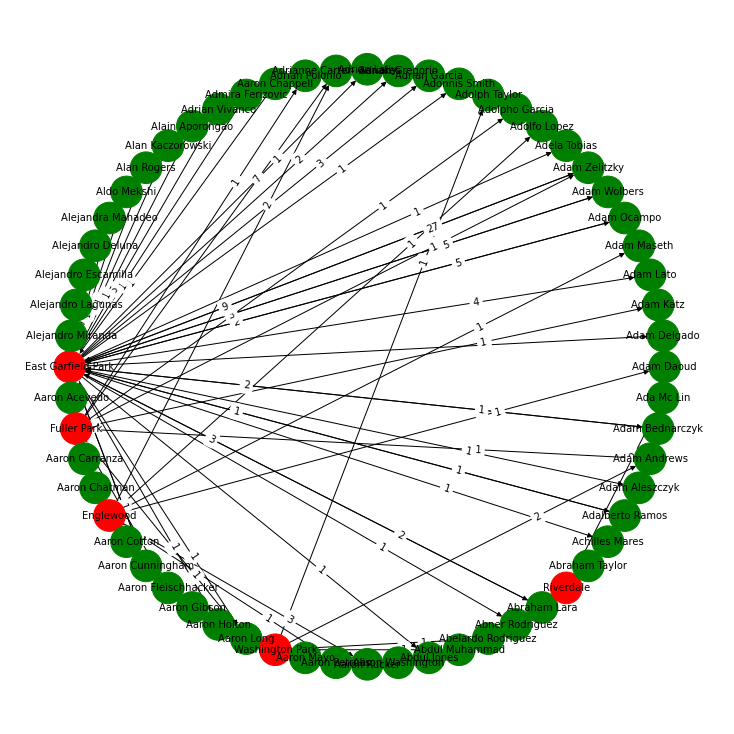

In [ ]:
#plot
plt.figure(figsize=(10,10)) 
pos = nx.shell_layout(g)
nx.draw(g, pos,with_labels=True, arrows = True,node_color = color_map,node_size=1000,font_size = 10)
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, label_pos=0.3, font_size=10)
plt.show()

#### Conclusion from graph
Since the graph is really huge, it is not possible to plot the whole graph here. However, we still can see there is tend for officers to have more TRRs and CRs from some communities (East Garfield Park on this graph). Therefore, we may find the potential connection between the victims and the officer by the location.

### 1.2.2 Graph Analysis on Location
Similarly, like the graph visualization, but we use all data now.

#### Build GraphFrame

In [ ]:
edges_query = "SELECT  d.name src, first_name || ' ' || last_name dst, d.id relationship FROM data_officerallegation a,data_allegation_areas b, data_officer c,data_area d WHERE a.allegation_id = b.allegation_id and a.officer_id = c.id and b.area_id = d.id and d.area_type = 'community';"
nodes_query = "SELECT name id From data_area Where area_type = 'community';"
edges_query_1 = "SELECT  first_name || ' ' || last_name src,community_id dst,a.beat_id relationship FROM data_officer,                (SELECT officer_id ,data_area.id AS beat_id FROM trr_trr                    LEFT JOIN data_area ON  beat::text = data_area.name                ) a,                (SELECT DISTINCT ON(1) table1.id as beat_id, table2.name as community_id FROM                                                                 (SELECT * FROM  data_area WHERE data_area.area_type ='beat')table1,                                                                 (SELECT * FROM  data_area WHERE data_area.area_type ='community')table2                WHERE ST_Contains(table2.polygon, table1.polygon) or st_intersects(table2.polygon, table1.polygon) ) m WHERE  a.beat_id = m.beat_id and data_officer.id = a.officer_id ;"

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465


cursor.execute(edges_query_1)
edges_1 = cursor.fetchall()
print("shape is: " + str(len(edges_1))) # 17465

df_edges = pd.DataFrame(edges)
df_edges.loc[:,2] = 'CR'
df_edges_1 = pd.DataFrame(edges_1)
df_edges_1.loc[:,2] = 'TRR'
df_edges = df_edges.append(df_edges_1)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

df_edges.head(5)

shape is: 204806
shape is: 35648


,src,dst,relationship
0,West Pullman,Daniel Houlihan,CR
1,Near West Side,Ray Gosberry,CR
2,South Lawndale,Walter Wronski,CR
3,Dunning,Robert Prokuski,CR
4,Grand Boulevard,Paul Bernatek,CR


In [ ]:
df_edges.tail(5)

,src,dst,relationship
35643,John Jankowski,West Garfield Park,TRR
35644,Anthony Brown,Austin,TRR
35645,Timothy Kinsella,East Garfield Park,TRR
35646,Pablo Guereca,Edgewater,TRR
35647,Allen Finley,Humboldt Park,TRR


In [ ]:
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)
cpdb = GraphFrame(nodes, edges_)

#### Graph Analysis

##### CRs:


>We can split the graph by its relationship between src and dst. For CRs, inDegress is the number of CRs an officer recieved, and outDegrees is the number of Crs a community complains.



In [ ]:
cr = cpdb.filterEdges("relationship = 'CR'")

In [ ]:
cr.inDegrees.sort(['inDegree'],ascending=[0]).show()

+-----------------+--------+
|               id|inDegree|
+-----------------+--------+
|       Joe Parker|     129|
|  Jerome Finnigan|     124|
|       Edward May|     114|
|  Charles Toussas|     114|
|      David Brown|     109|
|     Kevin Osborn|     108|
|  Maurice Clayton|     107|
|      Glenn Evans|     106|
|    Adam Zelitzky|     105|
|Jerome Turbyville|      99|
|     Robert Smith|      98|
|   Robert Johnson|      93|
|     James Grubbs|      93|
|      John Carney|      88|
|   Tyrone Jenkins|      87|
|  Gregory Jackson|      87|
|  Broderick Jones|      87|
|       Kevin Ryan|      85|
| Eugene Bikulcius|      85|
|    Edward Howard|      83|
+-----------------+--------+
only showing top 20 rows



In [ ]:
cr.outDegrees.sort(['outDegree'],ascending=[0]).show()

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|              Austin|    10470|
|      West Englewood|     7979|
|                Loop|     7927|
|      Near West Side|     7411|
|     Near North Side|     7327|
|      Auburn Gresham|     6009|
|       Humboldt Park|     5760|
|      North Lawndale|     5503|
|           Englewood|     5360|
|           West Town|     5267|
|         South Shore|     4932|
|  East Garfield Park|     4900|
|            New City|     4891|
|            Roseland|     4763|
|        Chicago Lawn|     4741|
|        Logan Square|     4368|
|           Lake View|     4114|
|Greater Grand Cro...|     4088|
|              Uptown|     3833|
|            Woodlawn|     3752|
+--------------------+---------+
only showing top 20 rows



##### TRRs:


>We can split the graph by its relationship between src and dst. For TRRs, inDgress is the number of TTRs happen in the community, and outDegrees is the number of TRRs an officer has.



In [ ]:
trr = cpdb.filterEdges("relationship = 'TRR'")

In [ ]:
trr.edges.show()

+-------------------+------------------+------------+
|                src|               dst|relationship|
+-------------------+------------------+------------+
|      Michael Jacob|       Rogers Park|         TRR|
|  Agustin Cervantes|          Avondale|         TRR|
|        Walter Ware|    North Lawndale|         TRR|
|         John Flisk|    North Lawndale|         TRR|
|      David Morales|    North Lawndale|         TRR|
|Demosthen Balodimas|    Belmont Cragin|         TRR|
|    Timothy Gilbert|East Garfield Park|         TRR|
|       Thomas Davey|    Near West Side|         TRR|
|     Brian Ferguson|     Humboldt Park|         TRR|
|       Paul Meagher|            Austin|         TRR|
|      Kent Erickson|            Uptown|         TRR|
|      Martin Teresi|           Beverly|         TRR|
|      Raymond Wilke|           Beverly|         TRR|
|   Nicolas Chapello|       Irving Park|         TRR|
|     Kerry Mc Guire|       Irving Park|         TRR|
|   Michael Leverett|East Ga

In [ ]:
trr.inDegrees.sort(['inDegree'],ascending=[0]).show()

+------------------+--------+
|                id|inDegree|
+------------------+--------+
|            Austin|    5721|
|     Humboldt Park|    2848|
|West Garfield Park|    2622|
|    South Lawndale|    2230|
|    North Lawndale|    2092|
|   Near North Side|    1721|
|    Near West Side|    1648|
|         West Town|    1607|
|East Garfield Park|    1502|
|    Belmont Cragin|    1064|
|         Lake View|    1033|
|       Rogers Park|     928|
|        North Park|     771|
|      Lincoln Park|     765|
|      Logan Square|     760|
|        West Ridge|     757|
|      Norwood Park|     747|
|            Uptown|     703|
|         Edgewater|     576|
|       Albany Park|     520|
+------------------+--------+
only showing top 20 rows



### 1.2.3 Conclusion
We can conclude that communities like Austin, West Englewood, and Loop have a high volume of complaint report to officers, and Austin, Humboldt Park, and West Garfield Park have a large amount of TRRs. From this result we can find in the high-income community, people are more likely to complain about the behavior of the police. People from low-income communities receive more "threats" of tactical response. One possible explanation is that people who live in high-income communities have time to report the misbehavior of over-policing officers. But in the low-income community, people have no power to against the over-policing. Anyway,  a high amount of reports of tactical response shows that there is potential over-policing behavior in those areas. Combining with the result we find in Checkpoint 1, a community like West Garfield Park is a low-income area. Therefore, we can assume that there is over-policing in the socio-economy status community.

# **Question 2**
Network dynamics of co-accused in each cohort can be interesting. The analytics can be done with the following:


1.   Make use of Triangle Count Algorithms for each cohort.
2.   Make use of the Page Rank Algorithm to find the most connected officer in all cohorts.
3. How many CRs that officers have and how many co-accused for each cohort.
4. Compare the top k largest cohort of police officers in high and low socio-economy status.


**Following query creates nodes and edges to answer the questions for co-accused allegations.**

1. Who among the officers have the most triangle counts?
2. Who have the most page rank score?
3. Are there any communities in the officers?
4. What are the allegation reports number for those officers inside a cluster?
5. What are the top large cohort of police officers in high and low socio-economy status?





**This is how we define the nodes and edges for the graph.**

*   **nodes**: id, officer name and allegation count
*   **edges**: src(officer1 id), dist(officer2 id) and relationship(allegation count)





**These queries are to draw co-accussed officers from allegation database. Basic logic is to join the allegation table with itself on the condition of the same allegation id and unequal officerid.**

**Nodes can be generated with data_officer table or allegation id by counting the number of allegation id. Here we chose data_officer table by removing Nan or 0s on allegation_count.**


Note: These queries are copied and modified from the GraphX demo class, which shares similar analysis goal as us.




### 2.1 Community finding by Label propagation

##### Build GraphFrame

In [ ]:
edges_query = "SELECT da1.officer_id src, da2.officer_id dst, COUNT(DISTINCT da1.allegation_id) relationship FROM data_officerallegation da1 JOIN data_officerallegation da2 ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id GROUP BY da1.officer_id, da2.officer_id ORDER BY count(*) DESC;"

In [ ]:
nodes_query = "SELECT  id, first_name || ' ' || last_name officer_name, allegation_count FROM data_officer where allegation_count > 0;"

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

In [ ]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

In [ ]:
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)
cpdb = GraphFrame(nodes, edges_)

**Label propagation algorithm is helpful to us for finding communities in officers. It is a semi-supervised algorithm which starts with a subset of labeled nodes and propagate the labels to unlabled data. After several iterations, all data are labeled and form a group of communities.**

**The first step here is to run the algorithm by calling the API. We have also presented the output here with a new column called label here to indicate the comminity id for all the nodes. Also, we found over 2,800 different comminities, which indicates the frequently-seen co-accused sceneario.**


Note: These code are copied and modified from the GraphX demo class, which shares similar analysis goal as us.




In [ ]:
communities = cpdb.labelPropagation(maxIter=20)
communities.persist().show(20)
print (f"There are {communities.select('label').distinct().count()} communities in this sample graph.")

+----+----------------+----------------+-----+
|  id|    officer_name|allegation_count|label|
+----+----------------+----------------+-----+
|  29|    Henry Abrams|               6| 6534|
| 474|Ignacio Alvarado|               7|28838|
| 964|  Colleen Austin|               6| 3744|
|1677|    Chad Behrend|              25|17372|
|1950|    Thomas Beyna|              22|  442|
|2214|    Calvin Blunt|              21|28273|
|2250|Kathleen Boehmer|               2|17372|
|2453|   Joseph Boston|              59|28838|
|2509|  Rosalind Bowie|              14|32382|
|2529|     Emmett Boyd|              11|12644|
|3091|  Michael Browne|               9|32041|
|3506|John Butterfield|               1| 3506|
|3764|   Sean Campbell|              90|28838|
|4894|Danyelle Cochran|               1| 4894|
|5385|  Gerald Corless|               2|27851|
|5409|  Rodolfo Corona|               4|17372|
|5556| Ramon Covington|               6|11980|
|7225|     Judy Dotson|               2| 7225|
|7279| Terren

Recognising the largest comminites are important. So we ranked the label propagtion algorithm result by sorting descendingly the number of members in the commnity.



In [ ]:
communities.select('label').groupby('label').count().sort(['count'],ascending=False).show(20)

+-----+-----+
|label|count|
+-----+-----+
|17372| 8316|
| 3744| 1636|
|29511| 1224|
|11980|  652|
|28273|  596|
|28838|  450|
|32014|  364|
|32068|  323|
|32382|  257|
|26622|  257|
|13631|  256|
|14106|  243|
|32274|  211|
|32041|  207|
| 6534|  187|
|18915|  186|
|23787|  173|
| 2981|  162|
|21912|  155|
|23033|  115|
+-----+-----+
only showing top 20 rows



In [ ]:
cpdb_com = GraphFrame(communities, edges_)

After identifying those top big communities, we are also interested in how the community are contructed and their internal architecture.

We plotted the 22809 community which is consisted of over 50 nodes. It is clear to us that officer 2612, 30237, and 21028 are among those "leading" nodes with multiple indegree and outdegrees inside the clique.



In [ ]:
cpdb_com1 = cpdb_com.filterVertices("label = 22809").dropIsolatedVertices()

In [ ]:
def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw_shell(g, with_labels=True, arrows = True, node_color='grey', node_size=1000,font_size = 10)

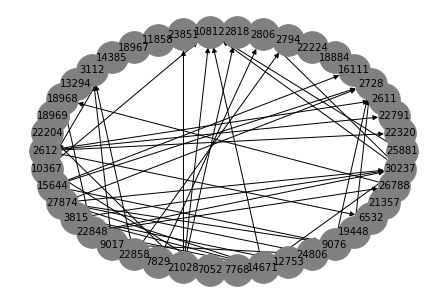

In [ ]:
plot_graph(cpdb_com1)

### 2.2 Triangle Count analysis

Triangle counting algorithm is to count the triangle like relationship among 3 nodes which have connected in pairs. We want to find out those outstanding nodes in the graph which have a lot more triangle counts.

In [ ]:
tc_cpdb = cpdb.triangleCount()
tc_cpdb.select("id", "count").show()

+-----+-----+
|   id|count|
+-----+-----+
|33748|    0|
|33751|    0|
|33724|    0|
|33798|    0|
|33755|    0|
|33746|    0|
|33749|    0|
|33737|    0|
|33725|    0|
|33738|    0|
|33728|    0|
|33752|    0|
|33711|    0|
|33723|    0|
|33750|    0|
|32312|   37|
|32358|  109|
|33753|    0|
|33758|    0|
|33709|    0|
+-----+-----+
only showing top 20 rows



In this part, we sorted all the nodes according to their triangle counts. We can see over 20 nodes appearing in over 18,000 triangle relationships, which indicates strong community leader potential like officer 6315 and 3033.

In [ ]:
tc_cpdb.sort(['count'],ascending=False).show()

+-----+-----+------------------+----------------+
|count|   id|      officer_name|allegation_count|
+-----+-----+------------------+----------------+
|32118| 6315|     Terence Davis|              38|
|32117| 3033|    Raimondo Brown|              17|
|32073| 3744|    Derek Campbell|               8|
|27855|18042|     Donald Mc Coy|              22|
|27823|  441|   Fernando Alonzo|              16|
|23900|21530|Michael Overstreet|              56|
|23518|27349|   Charles Stanton|              11|
|23499| 5180|    Stephen Conner|               9|
|23487| 5667|     Jerry Crawley|              30|
|23477|16747|     Evetta Lundin|               7|
|23475| 8844|      Thomas Flynn|              19|
|23472|23654|        Lloyd Reid|               4|
|23472|14750|   William Kissane|              23|
|20185|19856|   Ronald Muhammad|              11|
|19322| 8138|       Glenn Evans|             132|
|18773|29882|       Fred Waller|              49|
|18648|28273|      James Taylor|              36|


### 2.3 Page Rank analysis to find key nodes

Page rank algorithm is developed to find out important nodes inside a graph by iterations of calculations of the possiblities to get to the node by starting randomly.

In [ ]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.orderBy('pagerank', ascending=False).show()

+-----+------------------+----------------+------------------+
|   id|      officer_name|allegation_count|          pagerank|
+-----+------------------+----------------+------------------+
|32442|      John Zinchuk|              23|127.52903862900281|
|32440|       Mark Zawila|              34| 90.32581504596747|
|32425|    Perry Williams|              27| 75.93393690155354|
|32350|    Robert Spiegel|              20| 72.52408784740014|
|32410|     Joseph Watson|              29|  71.8959609008098|
|32430|    Michael Wrobel|              22|  70.6024730642657|
|32074|    Ronald Jenkins|              46| 70.26504490198167|
|32284|         Mark Reno|              76| 68.44254003101547|
|32351|  Boonserm Srisuth|              25| 66.23218732944623|
|32433|     Kenneth Yakes|              29| 63.74966193544296|
|32419|         Eric Wier|              18| 60.25243358901534|
|32384|     Edwin Utreras|              47| 59.71305480353141|
|32435|    Mohammad Yusuf|              22| 59.31175673

From the above calculations, we can identify officers with sigificant impact in the graph. For example, officer 32442 and 32440 are major part in the clique and may be the "bad apple" in the organization.

### 2.4 The Corelation Between Police Cohort and CRs/TRRs

In this section, each police are counted for the time they had the same allegation with other police officers. The counted number will then be compared with the CRs and TRRs they gave and received to find the correlation between them. The goal of the correlation is to find whether police officers are more likely to misconduct when working as a group.

#### Build GraphFrame

In [ ]:
edges_query = "SELECT  d.name src, first_name || ' ' || last_name dst, d.id relationship FROM data_officerallegation a,data_allegation_areas b, data_officer c,data_area d WHERE a.allegation_id = b.allegation_id and a.officer_id = c.id and b.area_id = d.id and d.area_type = 'community';"
nodes_query = "SELECT name id From data_area Where area_type = 'community';"
edges_query_1 = "SELECT  first_name || ' ' || last_name src,community_id dst,a.beat_id relationship FROM data_officer,                (SELECT officer_id ,data_area.id AS beat_id FROM trr_trr                    LEFT JOIN data_area ON  beat::text = data_area.name                ) a,                (SELECT DISTINCT ON(1) table1.id as beat_id, table2.name as community_id FROM                                                                 (SELECT * FROM  data_area WHERE data_area.area_type ='beat')table1,                                                                 (SELECT * FROM  data_area WHERE data_area.area_type ='community')table2                WHERE ST_Contains(table2.polygon, table1.polygon) or st_intersects(table2.polygon, table1.polygon) ) m WHERE  a.beat_id = m.beat_id and data_officer.id = a.officer_id ;"

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
cursor.execute(edges_query_1)
edges_1 = cursor.fetchall()
df_edges = pd.DataFrame(edges)
df_edges.loc[:,2] = 'CR'
df_edges_1 = pd.DataFrame(edges_1)
df_edges_1.loc[:,2] = 'TRR'
df_edges = df_edges.append(df_edges_1)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

shape is: 204806
shape is: 35648


,src,dst,relationship
0,West Pullman,Daniel Houlihan,CR
1,Near West Side,Ray Gosberry,CR
2,South Lawndale,Walter Wronski,CR
3,Dunning,Robert Prokuski,CR
4,Grand Boulevard,Paul Bernatek,CR


In [ ]:
edges_ = spark.createDataFrame(df_edges)
nodes = spark.createDataFrame(df_nodes)
cpdb = GraphFrame(nodes, edges_)

#### Graph Analysis

In [ ]:
cr = cpdb.filterEdges("relationship = 'CR'")

In [ ]:
trr = cpdb.filterEdges("relationship = 'TRR'")

In [ ]:
trr_out=trr.outDegrees.sort(['outDegree'],ascending=[0]).toPandas()
cr_in = cr.inDegrees.sort(['inDegree'],ascending=[0]).toPandas()

In [ ]:
officer_id = """SELECT DISTINCT first_name || ' ' || last_name id, officer_id officer_id FROM trr_trr, data_officer
    WHERE trr_trr.officer_id = data_officer.id"""

cursor.execute(officer_id)
officer = cursor.fetchall()
df_officer = pd.DataFrame(officer)
df_officer.columns =['id', 'officer_id']

,id,officer_id
0,Aaron Acevedo,56
1,Aaron Armstead,834
2,Aaron Burns,3412
3,Aaron Carranza,3978
4,Aaron Chappell,4423
...,...,...
10793,Ziad Hamideh,11260
10794,Zoe Batzer,1544
10795,Zohaib Zaib,31502
10796,Zoran Miucin,19297


In [ ]:
misconduct = pd.merge(cr_in, trr_out, how="left", on="id").fillna(0)
misconduct = pd.merge(misconduct, df_officer, how = "left", on = "id")
misconduct["cohart count"] = None
misconduct

,id,inDegree,outDegree,officer_id,cohart count
0,Joe Parker,129,0.0,21837.0,None
1,Jerome Finnigan,124,1.0,8562.0,None
2,Edward May,114,2.0,17816.0,None
3,Charles Toussas,114,0.0,NaN,None
4,David Brown,109,0.0,3005.0,None
...,...,...,...,...,...
21811,Bernard Domagala,1,0.0,NaN,None
21812,C Ahern,1,0.0,NaN,None
21813,Angel Ward,1,0.0,NaN,None
21814,Brittni Martinez,1,0.0,NaN,None


In [ ]:
same_case = "SELECT da1.officer_id src, da2.officer_id dst, COUNT(DISTINCT da1.allegation_id) relationship FROM data_officerallegation da1 JOIN data_officerallegation da2 ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id GROUP BY da1.officer_id, da2.officer_id ORDER BY count(*) DESC;"

cursor.execute(same_case)
case = cursor.fetchall()
df_case = pd.DataFrame(case)
df_case.columns =['member1', 'member2', 'co-case count']
df_case.head(5)

,member1,member2,co-case count
0,12478,32166,53
1,8562,27778,47
2,1553,10724,43
3,2725,21703,41
4,3605,14442,41


In [ ]:
cohart_count = []
for officer_id in misconduct["officer_id"]:
  if officer_id > 0:
    cohart_count.append(len(df_case["member1"][df_case["member1"] == int(officer_id)].index))
  else:
    cohart_count.append(0)
misconduct["cohart count"] = cohart_count
misconduct

,id,inDegree,outDegree,officer_id,degree,cohart count
10,Adam Zelitzky,105,36.0,31631.0,141.0,11
0,Joe Parker,129,0.0,21837.0,129.0,27
1,Jerome Finnigan,124,1.0,8562.0,125.0,119
2,Edward May,114,2.0,17816.0,116.0,86
3,Charles Toussas,114,0.0,NaN,114.0,0
...,...,...,...,...,...,...
19820,Andrzej Tyralski,1,0.0,29103.0,1.0,0
19821,Lawrence Carlson,1,0.0,NaN,1.0,0
19822,James Buckner,1,0.0,NaN,1.0,0
19823,Norman Irvin,1,0.0,NaN,1.0,0


In [ ]:
correlation_cr = misconduct["cohart count"].corr(misconduct["inDegree"])
correlation_trr = misconduct["cohart count"].corr(misconduct["outDegree"])

0.4336685095137671

In [ ]:
correlation_cr

0.4151983851569964

In [ ]:
correlation_trr

0.2105413964787558

#### Conclusion

The correlation between group allegation and complaint reports is positively correlated, and the group allegation is less correlated to tactical response reports. It is possible that when police officers are co-accused, they are more likely to have actual misconduct activity. It is because if they gave more tactical responses than receive complaints, or if they have a fairly equal amount of tactical responses and complaints, they would be less likely to have misconduct.